In [3]:
import os
import numpy as np

import torchvision.models as models
import torch
from torch.utils.data import DataLoader

from ignite.engine import (
    create_supervised_trainer,
    create_supervised_evaluator,
    Events
)

from ignite.metrics import Average

from product_matching.data.dataset import ProductMatchingDataset
from product_matching.data.augmentation import DataAugmentation

## Load training dataset

In [4]:
batch_size = 1
n_workers = 4
image_resize = 224

train_data = ProductMatchingDataset(
    images_path=os.path.join('datasets', 'dataset'),
    path=os.path.join('datasets', 'product_matching_dataset_toy', 'train.json'),
    image_resize=image_resize,
    data_augmentation=DataAugmentation()
)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=n_workers,
                          pin_memory=True)

## Visualize toy data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

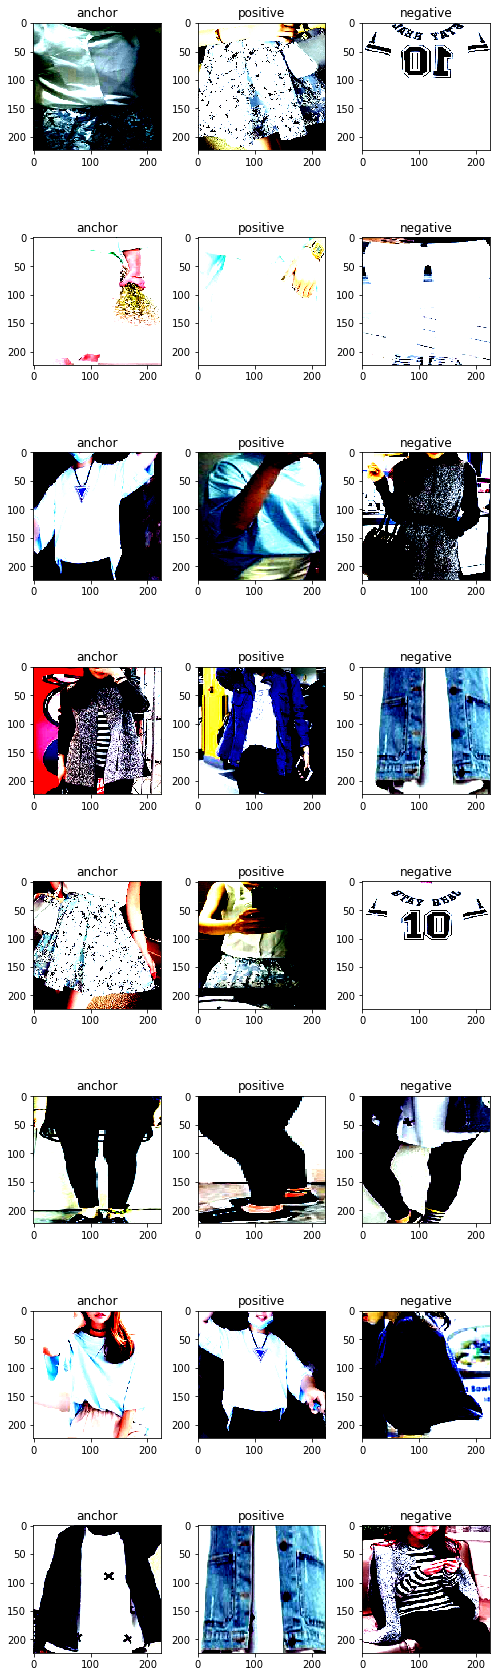

In [5]:
import random
import matplotlib.pyplot as plt

def _display(image, tag, ax):
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title(tag)

n_rows = len(train_data)
fig, axs = plt.subplots(n_rows, 3, figsize=(7.0, n_rows*3.0))

for i in range(len(train_data)):
    data, _ = train_data[i]
    anchor, positive, negative = data
    _display(anchor, 'anchor', axs[i][0])
    _display(positive, 'positive', axs[i][1])
    _display(negative, 'negative', axs[i][2])

plt.tight_layout()
plt.show()
        

## Load validation dataset

In [6]:
# TODO: change to validation
val_data = ProductMatchingDataset(
    images_path=os.path.join('datasets', 'dataset'),
    path=os.path.join('datasets', 'product_matching_dataset_toy', 'train.json'),
    image_resize=image_resize,
    data_augmentation=DataAugmentation()
)

val_loader = DataLoader(val_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=n_workers,
                          pin_memory=True)

## Create siamese network

In [7]:
class TripletNetwork(torch.nn.Module):
    
    def __init__(self):
        super(TripletNetwork, self).__init__()
        # https://stackoverflow.com/questions/55083642/extract-features-from-last-hidden-layer-pytorch-resnet18
        self._pretrained = models.resnet18(pretrained=False)
        self._embedding = torch.nn.Sequential(
            *list(self._pretrained.children())[:-1]
        )
        self._fc = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.Linear(128, 32),
            torch.nn.Linear(32, 4),
        )
    
    def forward(self, *args):
        
        def _compute_output(x):
#             return torch.flatten(self._embedding(x), start_dim=1, end_dim=-1).squeeze(-1).squeeze(-1)
            return self._fc(torch.flatten(self._embedding(x), start_dim=1, end_dim=-1)).squeeze(-1).squeeze(-1)


        anchor, positive, negative = args[0][0], args[0][1], args[0][2]
#         anchor, positive, negative = args[0], args[1], args[2]
        return _compute_output(anchor), _compute_output(positive), _compute_output(negative)


## Define training engine

In [28]:
LOSS_MARGIN = 1.0


def l2_squared_dist(t1, t2):
    return torch.sum(torch.pow(t1 - t2, 2), dim=-1)


def triplet_fn(output, margin):
    anchor, positive, negative = output
    batch_size = anchor.shape[0]
    zeros_vector = torch.zeros(batch_size, requires_grad=False).to(device)
    pos_dist = l2_squared_dist(anchor, positive)
    neg_dist = l2_squared_dist(anchor, negative)
    return torch.max(pos_dist - neg_dist + margin, zeros_vector)


def triplet_loss(output, target, margin):
    return torch.mean(triplet_fn(output, margin))


device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
net = TripletNetwork().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

trainer = create_supervised_trainer(
    net, 
    optimizer,
    lambda y_pred, y_true: triplet_loss(y_pred, y_true, margin=LOSS_MARGIN),
    device=device
)

## Define custom metrics

In [29]:
def positive_distance(output):
    batch, _ = output
    anchor, positive, negative = batch
    return torch.mean(l2_squared_dist(anchor, positive))

def negative_distance(output):
    batch, _ = output
    anchor, positive, negative = batch
    return torch.mean(l2_squared_dist(anchor, negative))

def non_zeros(output, margin):
    batch, _ = output
    return (triplet_fn(batch, margin) != 0).sum()


mean_positive_dist = Average(output_transform=positive_distance)
mean_negative_dist = Average(output_transform=negative_distance)
non_zeros_avg = Average(output_transform=lambda x: non_zeros(x, LOSS_MARGIN))

## Define evaluator

In [30]:
evaluator = create_supervised_evaluator(
    net,
    metrics={
        'positive_pair_dist': mean_positive_dist,
        'negative_pair_dist': mean_negative_dist,
        'non_zeros': non_zeros_avg
    },
    device=device
)

## Set handlers

In [31]:
# https://github.com/adambielski/siamese-triplet

In [ ]:
def log_metrics(engine, tag):
    print(
        '[{}] - {} - Loss: {:.2f}, Pos dist: {:.2f}, Neg dist: {:.2f}, Non-zeros: {:.2f}'.format(
            tag,
            trainer.state.epoch,
            trainer.state.output,
            engine.state.metrics['positive_pair_dist'],
            engine.state.metrics['negative_pair_dist'],
            engine.state.metrics['non_zeros']
        )
    )


@trainer.on(Events.EPOCH_COMPLETED)
def evaluate(trainer):
    with evaluator.add_event_handler(Events.COMPLETED, log_metrics, 'train'):
        evaluator.run(train_loader)

    with evaluator.add_event_handler(Events.COMPLETED, log_metrics, 'validation'):
        evaluator.run(val_loader)

trainer.run(train_loader, max_epochs=25)

[train] - 1 - Loss: 0.97, Pos dist: 285.52, Neg dist: 274.05, Non-zeros: 0.50
[validation] - 1 - Loss: 0.97, Pos dist: 466.46, Neg dist: 243.29, Non-zeros: 0.62
[train] - 2 - Loss: 0.98, Pos dist: 6445.09, Neg dist: 54809.68, Non-zeros: 0.12
[validation] - 2 - Loss: 0.98, Pos dist: 18491.28, Neg dist: 41448.80, Non-zeros: 0.50
[train] - 3 - Loss: 0.00, Pos dist: 42820.18, Neg dist: 110669.64, Non-zeros: 0.25
[validation] - 3 - Loss: 0.00, Pos dist: 34390.57, Neg dist: 88221.54, Non-zeros: 0.50
[train] - 4 - Loss: 0.96, Pos dist: 189.69, Neg dist: 626.09, Non-zeros: 0.38
[validation] - 4 - Loss: 0.96, Pos dist: 175.59, Neg dist: 370.81, Non-zeros: 0.38
[train] - 5 - Loss: 1.02, Pos dist: 53.57, Neg dist: 105.09, Non-zeros: 0.38


## TODO: check it overfits
    - Try using network from scratch
    - Try with pre-trained
    - TODO: plot scatter with TSNE
# TODO: use closests product on epoch finish to evaluate task
# TODO: add early stopping

## Check ignite

https://pytorch.org/ignite/quickstart.html